<a href="https://colab.research.google.com/github/dnrghks5583/Way-that-set-threshold-for-setting-PMD/blob/main/caltech101_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input
from tensorflow.keras.layers import Flatten, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
import math

# training parameters
batch_size = 32 # orig paper trained all networks with batch_size=128
epochs = 100
num_classes = 102
data_augmentation = True

# subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 9

# model version
# orig paper: version = 1 (ResNet v1), 
# improved ResNet: version = 2 (ResNet v2)
version = 1
path = '/content/gdrive/My Drive/caltech101_pickle'
image_size = (128, 128)
input_shape = (128, 128, 3)
num_classes = 102

In [3]:
import gzip
import pickle

os.chdir(path)

with gzip.open('caltech101_x_trainData_128.pickle', 'rb') as f:
    x_train = pickle.load(f)
    
with gzip.open('caltech101_x_testData_128.pickle', 'rb') as f:
    x_test = pickle.load(f)
    
with gzip.open('caltech101_y_trainData_128.pickle', 'rb') as f:
    y_train = pickle.load(f)
    
with gzip.open('caltech101_y_testData_128.pickle', 'rb') as f:
    y_test = pickle.load(f)

In [4]:
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# input image dimensions.
input_shape = x_train.shape[1:]

# normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# if subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('Model_Type : ' , model_type)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)
# convert class vectors to binary class matrices.
#y_train = to_categorical(y_train, num_classes)
#y_test = to_categorical(y_test, num_classes)

Model_Type :  ResNet56v1
x_train shape: (7316, 128, 128, 3)
7316 train samples
1829 test samples
y_train shape: (7316, 102)


In [5]:
def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    Arguments:
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    Returns:
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=num_classes):
    """ResNet Version 1 Model builder [a]
    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved
    (downsampled) by a convolutional layer with strides=2, while 
    the number of filters is doubled. Within each stage, 
    the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M
    Arguments:
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    Returns:
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, in [a])')
    # start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            # first layer but not first stack
            if stack > 0 and res_block == 0:  
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            # first layer but not first stack
            if stack > 0 and res_block == 0:
                # linear projection residual shortcut
                # connection to match changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, depth, num_classes=num_classes):
    """ResNet Version 2 Model builder [b]
    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or 
    also known as bottleneck layer.
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, 
    the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, 
    while the number of filter maps is
    doubled. Within each stage, the layers have 
    the same number filters and the same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256
    Arguments:
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    Returns:
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 110 in [b])')
    # start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU
    # on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                # first layer and first stage
                if res_block == 0:  
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                # first layer but not first stage
                if res_block == 0:
                    # downsample
                    strides = 2 

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection
                # to match changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = add([x, y])

        num_filters_in = num_filters_out

    # add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [6]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule(0)),
              metrics=['acc'])
model.summary()

# enable this if pydot can be installed
# pip install pydot
#plot_model(model, to_file="%s.png" % model_type, show_shapes=True)
print(model_type)

Learning rate:  0.001
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 16) 0           batch_normalization[0][0]        
________________________________________________________________________

In [7]:
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]
#callbacks = [checkpoint, lr_reducer, lr_scheduler]

# run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # this will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False)

Using real-time data augmentation.


In [8]:
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

steps_per_epoch =  math.ceil(len(x_train) / batch_size)
    # fit the model on the batches generated by datagen.flow().
model.fit(x=datagen.flow(x_train, y_train, batch_size=batch_size),
              verbose=1,
              epochs=epochs,
              validation_data=(x_test, y_test),
              steps_per_epoch=steps_per_epoch,
              callbacks=callbacks)


# score trained model
scores = model.evaluate(x_test,
                        y_test,
                        batch_size=batch_size,
                        verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Epoch 1/100
Learning rate:  0.001
229/229 [==============================] - 107s 304ms/step - loss: 4.6458 - acc: 0.2331 - val_loss: 4.1646 - val_acc: 0.2001
Epoch 2/100
Learning rate:  0.001
229/229 [==============================] - 71s 309ms/step - loss: 3.3787 - acc: 0.3584 - val_loss: 3.0874 - val_acc: 0.4297
Epoch 3/100
Learning rate:  0.001
229/229 [==============================] - 70s 307ms/step - loss: 2.8853 - acc: 0.4375 - val_loss: 2.9904 - val_acc: 0.4210
Epoch 4/100
Learning rate:  0.001
229/229 [==============================] - 72s 312ms/step - loss: 2.5774 - acc: 0.4836 - val_loss: 2.6155 - val_acc: 0.4943
Epoch 5/100
Learning rate:  0.001
229/229 [==============================] - 70s 307ms/step - loss: 2.3457 - acc: 0.5261 - val_loss: 2.4633 - val_acc: 0.5249
Epoch 6/100
Learning rate:  0.001
229/229 [==============================] - 71s 308ms/step - loss: 2.1542 - acc: 0.5631 - val_loss: 2.3047 - val_acc: 0.5424
Epoch 7/100
Learning rate:  0.001
229/229 [========

In [9]:
y_pred = model.predict(x_test)
model.evaluate(x_test, y_test)

58/58 [==============================] - 4s 75ms/step - loss: 1.5790 - acc: 0.7764


[1.5790202617645264, 0.7763805389404297]

In [10]:
import tensorflow

cce = tensorflow.keras.losses.categorical_crossentropy(
    y_test,
    y_pred,
    from_logits = False,
    label_smoothing = 0)
cce = cce.numpy()
print(cce)

[1.2872155e-03 1.1920930e-07 1.1920930e-07 ... 1.0638627e-01 9.0904301e-03
 1.0506958e-01]


In [11]:
def classification_Cce(cce, y_test, y_pred) :
  c = []
  m = []
  c_i = []

  for i in range(len(y_test)) :
    if np.argmax(y_test[i]) == np.argmax(y_pred[i]) :
      c.append(cce[i])
      c_i.append(i)
    else :
      m.append(cce[i])

  return c, m, c_i

In [12]:
collect_Cce, missclassification_Cce, collect_Idx = classification_Cce(cce, y_test, y_pred)
print(len(collect_Cce))
print(len(missclassification_Cce))

1420
409


In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

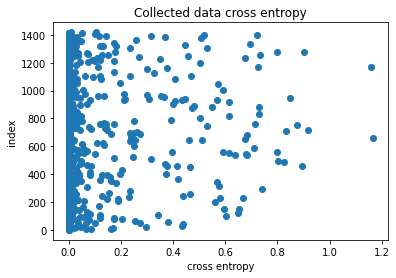

In [14]:
x_value = []
for i in range(len(collect_Cce)) :
  x_value.append(i)

plt.scatter(collect_Cce, x_value)
plt.title('Collected data cross entropy')
plt.ylabel('index')
plt.xlabel('cross entropy')
plt.show()

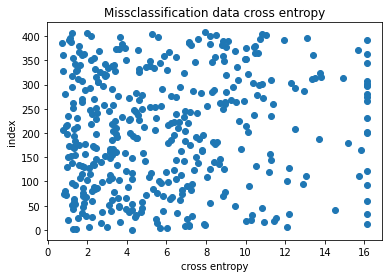

In [15]:
X_value = []
for i in range(len(missclassification_Cce)) :
  X_value.append(i)

plt.scatter(missclassification_Cce, X_value)
plt.title('Missclassification data cross entropy')
plt.ylabel('index')
plt.xlabel('cross entropy')
plt.show()

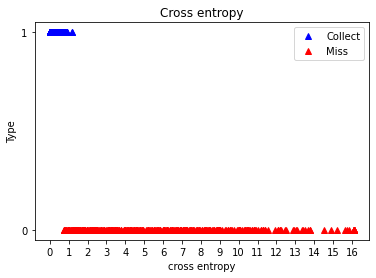

In [16]:
Y = []
for i in range(len(collect_Cce)) :
  Y.append(1)
y = []
for i in range(len(missclassification_Cce)) :
  y.append(0)

values = [0, 1, 2, 3, 4, 5, 6, 7, 8 ,9, 10, 11, 12 ,13, 14, 15, 16]

plt.plot(collect_Cce, Y, 'b^', missclassification_Cce, y, 'r^')
plt.title('Cross entropy')
plt.ylabel('Type')
plt.xlabel('cross entropy')
plt.legend(['Collect', 'Miss'])
plt.yticks([1,0])
plt.xticks(values)

plt.show()

In [17]:
print(max(collect_Cce))
print(min(missclassification_Cce))

1.1666403
0.7434929


In [18]:
section = []
section_rate = []
max_m = round(max(missclassification_Cce))

for i in range(max_m+1) :
  section.append(0)

for m in missclassification_Cce :
  section[round(m)] = section[round(m)] + 1

  
for i in range(max_m+1):
    section_rate.append(section[i]/len(missclassification_Cce))

print(section)
print(section_rate)

[0, 47, 57, 45, 36, 30, 31, 32, 26, 23, 21, 18, 9, 6, 4, 3, 21]
[0.0, 0.11491442542787286, 0.1393643031784841, 0.1100244498777506, 0.08801955990220049, 0.07334963325183375, 0.07579462102689487, 0.07823960880195599, 0.06356968215158924, 0.05623471882640587, 0.05134474327628362, 0.044009779951100246, 0.022004889975550123, 0.014669926650366748, 0.009779951100244499, 0.007334963325183374, 0.05134474327628362]


In [19]:
def static_Threshold() :
  threshold = []
  for i in range(1, 10):
    threshold.append(round(i * 0.1, 1))
  return threshold

In [20]:
staticThreshold = static_Threshold()
print(staticThreshold)

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


In [26]:
def dynamic_Threshold(missclassification_Cce, cce) :
  #Z = [1.96, 2.17, 2.576] # 95%, 97%, 99% two-tails
  Z = [1.645, 1.96, 2.326] # 95%, 97.5%, 99% one-tails
  threshold = [min(missclassification_Cce)]
  x_ = np.mean(cce)
  o = np.std(missclassification_Cce)
  n_ = (len(missclassification_Cce))**0.5

  for z in Z :
    threshold.append(x_- (z * o)/n_)
  
  return threshold

In [27]:
dynamicThreshold = dynamic_Threshold(missclassification_Cce, cce)
print(dynamicThreshold)

[0.7434929, 1.04800775514659, 0.9837800629025942, 0.9091536014381421]


In [23]:
def detection(threshold, cce, collect) : 
  PMD = []
  for i in collect :
    if cce[i] > threshold :
        PMD.append(i)
  return PMD

In [24]:
def detection_PMD(list_of_threshold, cce, collect):
  PMD_by_threshold = []

  for th in list_of_threshold :
    PMD_by_threshold.append(detection(th, cce, collect))
  return PMD_by_threshold

In [25]:
PMD_By_Static_Threshold  = detection_PMD(staticThreshold, cce, collect_Idx)
PMD_By_Dynamic_Threshold = detection_PMD(dynamicThreshold, cce, collect_Idx)

In [28]:
print(len(PMD_By_Static_Threshold))
print(PMD_By_Static_Threshold)
print(len(PMD_By_Dynamic_Threshold))
print(PMD_By_Dynamic_Threshold)

9
[[8, 12, 21, 32, 51, 60, 64, 65, 76, 94, 97, 106, 109, 123, 131, 137, 156, 192, 197, 221, 254, 263, 279, 280, 291, 292, 302, 304, 313, 324, 336, 352, 377, 401, 437, 446, 456, 458, 465, 485, 509, 511, 520, 522, 556, 584, 590, 594, 597, 610, 630, 631, 655, 662, 680, 694, 695, 700, 701, 719, 724, 725, 730, 762, 781, 790, 807, 810, 831, 840, 847, 849, 851, 869, 880, 891, 902, 903, 916, 918, 921, 928, 940, 941, 955, 957, 977, 989, 994, 995, 996, 998, 1000, 1026, 1032, 1052, 1072, 1091, 1150, 1151, 1155, 1168, 1182, 1206, 1209, 1220, 1224, 1226, 1232, 1233, 1237, 1242, 1253, 1255, 1256, 1257, 1269, 1272, 1308, 1363, 1375, 1413, 1417, 1437, 1438, 1445, 1466, 1474, 1508, 1513, 1524, 1525, 1528, 1559, 1573, 1580, 1582, 1600, 1606, 1609, 1619, 1624, 1629, 1632, 1635, 1654, 1660, 1664, 1694, 1695, 1712, 1713, 1714, 1716, 1725, 1735, 1759, 1778, 1789, 1796, 1797, 1799, 1803, 1804, 1826, 1828], [21, 32, 51, 60, 65, 76, 94, 123, 131, 156, 192, 197, 254, 291, 292, 302, 313, 324, 352, 377, 401, 446,

In [29]:
import cv2

In [30]:
def rotate_img_set(data_set, angle) : # 10' ~ 90'
  rotated_img = []
  print("rotate " + str(angle) + "degree")
  for img in data_set :
    m = cv2.getRotationMatrix2D((64, 64), angle, 1)
    new_img = cv2.warpAffine(img, m, (128, 128), cv2.INTER_AREA, borderMode = 1)
    rotated_img.append(new_img)
    
  return rotated_img

In [31]:
def img_trim(img, size) :
  w = 128
  h = 128
  new_img = img[size:size+h, size:size+w]
  return new_img

In [32]:
def size_Adjust(x_test, rate) :

  new_data_set = []
  if rate > 1 : # aggmentation
    print("augmentation " + str(rate) + "%")
    size = round(128*rate/2 - 64)
    for img in x_test :
      new_img = cv2.resize(img, None, fx = rate, fy = rate, interpolation = cv2.INTER_LINEAR)
      new_img = img_trim(new_img, size)
      new_data_set.append(new_img)
  else :  # reduction
    print("reduction " + str(rate) + "%")
    size = round(64 * (1-rate))
    for img in x_test :
      new_img = cv2.resize(img, None, fx = rate, fy = rate, interpolation = cv2.INTER_AREA)
      new_img = np.pad(new_img, ((size, size), (size, size), (0, 0)), mode = 'edge')
      new_img = cv2.resize(new_img, (128, 128), interpolation = cv2.INTER_AREA)
      new_data_set.append(new_img)

  return new_data_set

In [33]:
def get_MD(y_pred, new_y_pred, y_test) :
  MD = []
  for i in range(len(y_pred)) :
    if np.argmax(y_pred[i]) == np.argmax(y_test[i]) and np.argmax(new_y_pred[i]) != np.argmax(y_test[i]) :
      MD.append(i)
  print("    Find MD : " + str(len(MD)))
  return MD

In [34]:
def calc_Acc(new_y_pred, y_test) :
  cnt = 0
  for i in range(len(y_pred)) :
    if np.argmax(new_y_pred[i]) == np.argmax(y_test[i]) :
      cnt = cnt + 1
  acc = cnt/len(y_pred)
  print("  Acc : " + str(acc))

In [35]:
def get_PMD_Precision(MD, PMD) :
  cnt = 0
  if len(PMD) == 0 :
    return 0
  for data in PMD : 
    if data in MD :
      cnt = cnt + 1
  precision = cnt/len(PMD)
  print("        Precision : " + str(precision))
  return precision

In [36]:
def get_PMD_Recall(MD, PMD) :
  cnt = 0
  if len(MD) == 0 :
    return 0
  for data in MD : 
    if data in PMD :
      cnt = cnt + 1
  recall = cnt/len(MD)
  print("        Recall : " + str(recall))
  return recall

In [50]:
def get_Result(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, data_set, y_pred, y_test) : #
  Stp = []   # [ th = 0.1_pre1, th = 0.2_pre2, ... , th = 0.9_pre9 ] number of elements = 9
  Dtp = []   # [ th = min_pre1, th = 95%_pre2, ... , th = 99%_pre4 ] number of elements = 4
  Str = []   # [ th = 0.1_rec1, th = 0.2_rec2, ... , th = 0.9_rec9 ] number of elements = 9
  Dtr = []   # [ th = min_rec1, th = 95%_rec2, ... , th = 99%_rec4 ] number of elements = 4
  st = 1
  dt = 1

  new_y_pred = model.predict(data_set)
  calc_Acc(new_y_pred, y_test)
  MD = get_MD(y_pred, new_y_pred, y_test)

  print("      " + "static threshold")
  for s in PMD_By_Static_Threshold :
    print("        " + str(st) + "st static threshold")
    st = st + 1
    Stp.append(get_PMD_Precision(MD, s))
    Str.append(get_PMD_Recall(MD, s))
    print()

  print("      " + "dynamic threshold")
  for d in PMD_By_Dynamic_Threshold :
    print("        " + str(dt) + "st dynamic threshold")
    dt = dt + 1
    Dtp.append(get_PMD_Precision(MD, d))
    Dtr.append(get_PMD_Recall(MD, d))
    print()

  return Stp, Dtp, Str, Dtr

In [38]:
def get_Avg_Result(lists) : #
  x = len(lists[0]) # static = 9, dynamic = 4
  y = len(lists)    # aggmentation, reduction = 4, rotate = 9
  Avg = []

  for i in range(x) :
    temp = 0
    for j in range(y) :
      temp = temp + lists[j][i]
    Avg.append(temp/y)
  return Avg

In [39]:
def validation(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, y_pred, y_test, list_of_rate, rotated = False) : #

  stp_Result = []
  dtp_Result = []
  str_Result = []
  dtr_Result = []

  for rate in list_of_rate :
    if rotated :
      data_set = rotate_img_set(x_test, rate)
    else :
      data_set = size_Adjust(x_test, rate)
    data_set = np.array(data_set)

    Stp, Dtp, Str, Dtr = get_Result(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, data_set, y_pred, y_test)
    stp_Result.append(Stp)
    dtp_Result.append(Dtp)
    str_Result.append(Str)
    dtr_Result.append(Dtr)

  stp_Result = get_Avg_Result(stp_Result)
  dtp_Result = get_Avg_Result(dtp_Result)
  str_Result = get_Avg_Result(str_Result)
  dtr_Result = get_Avg_Result(dtr_Result)
  return stp_Result, dtp_Result, str_Result, dtr_Result

In [40]:
def print_Result(stp_Result, dtp_Result, str_Result, dtr_Result, comments, staticThreshold, dynamicThreshold) :
  print(comments)
  print(staticThreshold)
  print(stp_Result)
  print(str_Result)
  print(dynamicThreshold)
  print(dtp_Result)
  print(dtr_Result)

In [41]:
list_of_ag_rate = [1.1, 1.2, 1.3, 1.4]
list_of_rd_rate = [0.9, 0.8, 0.7, 0.6]
list_of_degree = [10, 20, 30, 40, 50, 60 ,70, 80 ,90]

In [51]:
rot_Stp, rot_Dtp, rot_Str, rot_Dtr = validation(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, y_pred, y_test, list_of_degree, True)   ## rotated

rotate 10degree
  Acc : 0.74412247129579
    Find MD : 113
      static threshold
        1st static threshold
        Precision : 0.41566265060240964
        Recall : 0.6106194690265486

        2st static threshold
        Precision : 0.44144144144144143
        Recall : 0.4336283185840708

        3st static threshold
        Precision : 0.46511627906976744
        Recall : 0.35398230088495575

        4st static threshold
        Precision : 0.4492753623188406
        Recall : 0.2743362831858407

        5st static threshold
        Precision : 0.5294117647058824
        Recall : 0.23893805309734514

        6st static threshold
        Precision : 0.5294117647058824
        Recall : 0.1592920353982301

        7st static threshold
        Precision : 0.7
        Recall : 0.12389380530973451

        8st static threshold
        Precision : 0.7
        Recall : 0.061946902654867256

        9st static threshold
        Precision : 1.0
        Recall : 0.035398230088495575

      dy

In [52]:
ag_Stp, ag_Dtp, ag_Str, ag_Dtr = validation(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, y_pred, y_test, list_of_ag_rate, False)    ## augmentation

augmentation 1.1%
  Acc : 0.7665390924002187
    Find MD : 82
      static threshold
        1st static threshold
        Precision : 0.29518072289156627
        Recall : 0.5975609756097561

        2st static threshold
        Precision : 0.36036036036036034
        Recall : 0.4878048780487805

        3st static threshold
        Precision : 0.3953488372093023
        Recall : 0.4146341463414634

        4st static threshold
        Precision : 0.391304347826087
        Recall : 0.32926829268292684

        5st static threshold
        Precision : 0.37254901960784315
        Recall : 0.23170731707317074

        6st static threshold
        Precision : 0.35294117647058826
        Recall : 0.14634146341463414

        7st static threshold
        Precision : 0.5
        Recall : 0.12195121951219512

        8st static threshold
        Precision : 0.7
        Recall : 0.08536585365853659

        9st static threshold
        Precision : 0.75
        Recall : 0.036585365853658534

    

In [53]:
rd_Stp, rd_Dtp, rd_Str, rd_Dtr = validation(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, y_pred, y_test, list_of_rd_rate, False)   ## reduction

reduction 0.9%
  Acc : 0.7599781301257518
    Find MD : 76
      static threshold
        1st static threshold
        Precision : 0.3433734939759036
        Recall : 0.75

        2st static threshold
        Precision : 0.3963963963963964
        Recall : 0.5789473684210527

        3st static threshold
        Precision : 0.4418604651162791
        Recall : 0.5

        4st static threshold
        Precision : 0.4782608695652174
        Recall : 0.4342105263157895

        5st static threshold
        Precision : 0.49019607843137253
        Recall : 0.32894736842105265

        6st static threshold
        Precision : 0.5294117647058824
        Recall : 0.23684210526315788

        7st static threshold
        Precision : 0.55
        Recall : 0.14473684210526316

        8st static threshold
        Precision : 0.7
        Recall : 0.09210526315789473

        9st static threshold
        Precision : 0.75
        Recall : 0.039473684210526314

      dynamic threshold
        1st dy

In [47]:
print_Result(rot_Stp, rot_Dtp, rot_Str, rot_Dtr, "Rotation", staticThreshold, dynamicThreshold)

Rotation
[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
[0.7590361445783134, 0.7687687687687688, 0.7777777777777778, 0.7777777777777778, 0.7908496732026143, 0.7875816993464052, 0.8055555555555555, 0.8888888888888891, 0.9722222222222222]
[0.18125252869281813, 0.12494508257280633, 0.09966873930827279, 0.07897592291684365, 0.06254251463909137, 0.041347935858611615, 0.028031739116850127, 0.014845304275075593, 0.007337461137379193]
[0.7434929, 1.04800775514659, 0.9837800629025942, 0.9091536014381421]
[0.8518518518518519, 1.0, 1.0, 1.0]
[0.01798243987126882, 0.0037191897472141702, 0.0037191897472141702, 0.005578784620821255]


In [48]:
print_Result(ag_Stp, ag_Dtp, ag_Str, ag_Dtr, "Augmentation", staticThreshold, dynamicThreshold)

Augmentation
[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
[0.4262048192771084, 0.4729729729729729, 0.497093023255814, 0.5, 0.48039215686274506, 0.47058823529411764, 0.6125, 0.7499999999999999, 0.625]
[0.390195293608517, 0.29660201858458796, 0.24585454751530997, 0.1967268921435327, 0.1394189553940949, 0.0897976099078049, 0.0718586769365815, 0.04530734329311043, 0.015707229161834466]
[0.7434929, 1.04800775514659, 0.9837800629025942, 0.9091536014381421]
[0.7291666666666666, 0.625, 0.625, 0.75]
[0.05235126103440732, 0.0062572044545836005, 0.0062572044545836005, 0.012658448674029588]


In [49]:
print_Result(rd_Stp, rd_Dtp, rd_Str, rd_Dtr, "Reduction", staticThreshold, dynamicThreshold)

Reduction
[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
[0.5557228915662651, 0.6081081081081081, 0.6395348837209303, 0.6557971014492754, 0.6617647058823529, 0.6691176470588236, 0.625, 0.7249999999999999, 0.75]
[0.4680778572149272, 0.35261118849400536, 0.29355085894715066, 0.2479187886966224, 0.18474472953023618, 0.1280285529715128, 0.07196914603214964, 0.044218900380569734, 0.01835544718182001]
[0.7434929, 1.04800775514659, 0.9837800629025942, 0.9091536014381421]
[0.7291666666666666, 0.875, 0.875, 0.8333333333333333]
[0.05422967250189669, 0.00920972696360724, 0.00920972696360724, 0.014594275384401938]
